In [ ]:
# Loading in pacakages and functions 

# ------------------------------------------------------
# Load packages
# ------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os

import ECM_function_first_iteration as km 




# Only likelihood comparesons

In [ ]:

# Results save directory
OUT_DIR = r"C:\Users\hhn54\OneDrive\Dokumenter\Speciale\Resultater"

# Nobs to run and number of Monte carlo runs
Ns = [100, 500, 1000, 10000]
M  = 10


# Setting parameters for data generation 
lam_true = 2.0
mu_true  = 1.5

R_true = np.array([[0.70, 0.30],
                   [0.20, 0.80]], dtype=float)


# Ensure output folder exists
os.makedirs(OUT_DIR, exist_ok=True)

# Results saves strorage
rows_summary = []
rows_runs = []         
rows_ll_traj = []       
ll_hists_all = {}       


# Monotonicity check (allow tiny numerical noise)
def is_monotone_nondecreasing(x, tol=1e-10):
    x = np.asarray(x, float)
    if x.size < 2:
        return True
    return bool(np.all(np.diff(x) >= -tol))


# Helper: feasibility rate (deterministic Z = Y R^{-1})
def feasibility_rate_YRinv(Y, R, feas_tol):
    # solve Z = Y R^{-1} via linear solves for stability
    # Y is (N,2), R is (2,2)
    # We want Z = Y @ inv(R). Equivalent to solving R^T x^T = Y^T
    # but simplest and stable: solve for each row: z R = y  -> R^T z^T = y^T
    Rt = R.T
    Z = np.linalg.solve(Rt, Y.T).T  # shape (N,2)
    return float(np.mean(np.min(Z, axis=1) >= -feas_tol))

# --------------------
# Running the algorithm
# --------------------
for N in Ns:
    # For N-level summary
    true_ll_list = []
    est_ll_list  = []
    time_list    = []
    delta_po_list = []  
    iters_list    = []
    mono_list     = []
    conv_list     = []
    feas_rate_list = [] 

    fit_ok = 0
    ll_ok  = 0

    for m in range(M):
        # Independent random geenrator per (N, m), testing different seeds, and inital conditions
        seed = 10_000*m + N + 1234
        rng = np.random.default_rng(seed)

        # Simulate data for each monte carlo run
        _, Z_all, Y, *_ = km.simulate_kulkarni_dataset(lam_true, mu_true, R_true, N=N, rng=rng)

        # initial conditions
        lam0 = lam_true + rng.normal(scale=1.0)
        mu0  = mu_true  + rng.normal(scale=1.0)
        u0   = km.u_from_R(R_true) + rng.normal(scale=0.5, size=2)

        # time calculation set
        t0 = time.perf_counter()
        try:
            lam_hat, mu_hat, R_hat, ll_hist = km.run_em(
                Y,
                lam0=lam0,
                mu0=mu0,
                u0=u0,
                max_iter=200,
                max_R_inner_steps=50,
                ll_tol_per_obs=1e-7,
                min_iter=5,
                verbose=False,
                track_ll=True,
                tol=km.TOL_Z,
            )
            t1 = time.perf_counter()
            fit_ok += 1
            fit_success = True
            fit_error = ""
        except RuntimeError as e:
            t1 = time.perf_counter()
            fit_success = False
            fit_error = str(e)

            # Still record that this run failed (so you "save all values")
            rows_runs.append({
                "N": N,
                "m": m,
                "seed": seed,
                "fit_success": False,
                "fit_error": fit_error,
                "runtime_sec": t1 - t0,
                "lam0": lam0,
                "mu0": mu0,
                "u0_1": float(u0[0]),
                "u0_2": float(u0[1]),
                # no estimates
                "lam_hat": np.nan,
                "mu_hat": np.nan,
                "R_hat_11": np.nan,
                "R_hat_12": np.nan,
                "R_hat_21": np.nan,
                "R_hat_22": np.nan,
                "ll_true": np.nan,
                "ll_est": np.nan,
                "ll_true_per_obs": np.nan,
                "ll_est_per_obs": np.nan,
                "delta_ll_per_obs": np.nan,
                "iters": np.nan,
                "ll_monotone": np.nan,
                "converged_flag": np.nan,
                "final_abs_dll_per_obs": np.nan,
                "ll_hist_len": np.nan,
                "feas_rate": np.nan,  # NEW
            })
            continue

        runtime = t1 - t0

        # evaluate likelihoods
        ll_true_m = km.loglik_Y(Y, lam_true, mu_true, R_true, tol=km.TOL_Z)
        ll_est_m  = km.loglik_Y(Y, lam_hat,  mu_hat,  R_hat,  tol=km.TOL_Z)

        #feasibility rate for this run at estimated R_hat
        feas_tol = km.TOL_Z
        try:
            feas_rate = feasibility_rate_YRinv(Y, R_hat, feas_tol=feas_tol)
        except Exception:
            feas_rate = np.nan

        # If ll invalid, record and skip from N-level stats (but still save run)
        if not (np.isfinite(ll_true_m) and np.isfinite(ll_est_m)):
            rows_runs.append({
                "N": N,
                "m": m,
                "seed": seed,
                "fit_success": True,
                "fit_error": "",
                "runtime_sec": runtime,
                "lam0": lam0,
                "mu0": mu0,
                "u0_1": float(u0[0]),
                "u0_2": float(u0[1]),
                "lam_hat": float(lam_hat),
                "mu_hat": float(mu_hat),
                "R_hat_11": float(R_hat[0, 0]),
                "R_hat_12": float(R_hat[0, 1]),
                "R_hat_21": float(R_hat[1, 0]),
                "R_hat_22": float(R_hat[1, 1]),
                "ll_true": float(ll_true_m),
                "ll_est": float(ll_est_m),
                "ll_true_per_obs": float(ll_true_m) / N if np.isfinite(ll_true_m) else np.nan,
                "ll_est_per_obs": float(ll_est_m) / N if np.isfinite(ll_est_m) else np.nan,
                "delta_ll_per_obs": np.nan,
                "iters": int(len(ll_hist)) if ll_hist is not None else np.nan,
                "ll_monotone": np.nan,
                "converged_flag": np.nan,
                "final_abs_dll_per_obs": np.nan,
                "ll_hist_len": int(len(ll_hist)) if ll_hist is not None else np.nan,
                "feas_rate": feas_rate,  # NEW
            })
            continue

        ll_ok += 1

        # --- diagnostics from ll_hist ---
        ll_hist = np.asarray(ll_hist, dtype=float)
        ll_hist = ll_hist[np.isfinite(ll_hist)]
        iters = int(ll_hist.size)

        # per-observation scale
        ll_hist_po = ll_hist / N if iters > 0 else np.array([], float)

        # monotonicity (on stored ll history)
        mono = is_monotone_nondecreasing(ll_hist, tol=1e-10)

        # convergence proxy: final |Δll|/N (matches your figure definition)
        if iters >= 2:
            final_abs_dll_po = float(abs(ll_hist_po[-1] - ll_hist_po[-2]))
        else:
            final_abs_dll_po = np.nan

        # If you want a Boolean "converged" flag aligned with your stop criterion:
        converged_flag = bool((iters >= 5) and np.isfinite(final_abs_dll_po) and (final_abs_dll_po <= 1e-7))

        # save history if you still want it
        if iters > 0:
            ll_hists_all.setdefault(N, []).append(ll_hist.copy())

        # Optional: save per-iteration trajectory (long format)
        for k, llk in enumerate(ll_hist_po, start=1):
            rows_ll_traj.append({
                "N": N,
                "m": m,
                "seed": seed,
                "iter": k,
                "ll_per_obs": float(llk),
            })

        # compute per-run summary quantities
        ll_true_po = float(ll_true_m) / N
        ll_est_po  = float(ll_est_m)  / N
        delta_po   = ll_est_po - ll_true_po

        # Store per-run diagnostics (this is the "all values through the loop")
        rows_runs.append({
            "N": N,
            "m": m,
            "seed": seed,
            "fit_success": True,
            "fit_error": "",
            "runtime_sec": runtime,
            "lam0": lam0,
            "mu0": mu0,
            "u0_1": float(u0[0]),
            "u0_2": float(u0[1]),
            "lam_hat": float(lam_hat),
            "mu_hat": float(mu_hat),
            "R_hat_11": float(R_hat[0, 0]),
            "R_hat_12": float(R_hat[0, 1]),
            "R_hat_21": float(R_hat[1, 0]),
            "R_hat_22": float(R_hat[1, 1]),
            "ll_true": float(ll_true_m),
            "ll_est": float(ll_est_m),
            "ll_true_per_obs": ll_true_po,
            "ll_est_per_obs": ll_est_po,
            "delta_ll_per_obs": float(delta_po),
            "iters": iters,
            "ll_monotone": mono,
            "converged_flag": converged_flag,
            "final_abs_dll_per_obs": final_abs_dll_po,
            "ll_hist_len": iters,
            "feas_rate": feas_rate,  # NEW
        })

        # For N-level summary
        time_list.append(runtime)
        true_ll_list.append(ll_true_m)
        est_ll_list.append(ll_est_m)
        delta_po_list.append(delta_po)
        iters_list.append(iters)
        mono_list.append(mono)
        conv_list.append(converged_flag)
        feas_rate_list.append(feas_rate)  # NEW

    # --- N-level summary df row ---
    true_ll_arr = np.asarray(true_ll_list, dtype=float)
    est_ll_arr  = np.asarray(est_ll_list, dtype=float)

    mean_true_ll = float(np.mean(true_ll_arr)) if true_ll_arr.size else np.nan
    mean_est_ll  = float(np.mean(est_ll_arr))  if est_ll_arr.size  else np.nan

    # per-observation gap mean + sd
    delta_po_arr = np.asarray(delta_po_list, dtype=float)
    delta_po_mean = float(np.mean(delta_po_arr)) if delta_po_arr.size else np.nan
    delta_po_sd   = float(np.std(delta_po_arr, ddof=1)) if delta_po_arr.size > 1 else np.nan

    # runtime
    mean_time_sec = float(np.mean(time_list)) if time_list else np.nan

    # iterations
    iters_arr = np.asarray(iters_list, dtype=float)
    iters_med = float(np.median(iters_arr)) if iters_arr.size else np.nan
    iters_p90 = float(np.quantile(iters_arr, 0.90)) if iters_arr.size else np.nan

    # monotonicity rate and convergence rate
    mono_rate = float(np.mean(mono_list)) if mono_list else np.nan
    conv_rate = float(np.mean(conv_list)) if conv_list else np.nan

    #feasibility rate mean + sd across runs
    feas_arr = np.asarray(feas_rate_list, dtype=float)
    feas_rate_mean = float(np.mean(feas_arr)) if feas_arr.size else np.nan
    feas_rate_sd   = float(np.std(feas_arr, ddof=1)) if feas_arr.size > 1 else np.nan

    rows_summary.append({
        "N": N,
        "True_logLik_mean": mean_true_ll,
        "Est_logLik_mean":  mean_est_ll,
        "delta_ll_per_obs_mean": delta_po_mean,   
        "delta_ll_per_obs_sd":   delta_po_sd,
        "mean_time_sec": mean_time_sec,
        "fit_ok": int(fit_ok),
        "ll_ok":  int(ll_ok),
        "conv_rate": conv_rate,
        "mono_rate": mono_rate,
        "iters_median": iters_med,
        "iters_p90": iters_p90,
        "feas_rate_mean": feas_rate_mean,   
        "feas_rate_sd":   feas_rate_sd,    
        "saved_histories": len(ll_hists_all.get(N, [])),
        "feas_tol": feas_tol,
    })


# Build DF for results
df_summary = pd.DataFrame(rows_summary)
df_runs    = pd.DataFrame(rows_runs)

# Optional: trajectory DF (can be large)
df_ll_traj = pd.DataFrame(rows_ll_traj) if rows_ll_traj else pd.DataFrame()


# Save to CSV
summary_path = os.path.join(OUT_DIR, "kulkarni_em_summary_diagnostics.csv")
runs_path    = os.path.join(OUT_DIR, "kulkarni_em_runs_diagnostics.csv")
traj_path    = os.path.join(OUT_DIR, "kulkarni_em_ll_trajectory_long.csv")

df_summary.to_csv(summary_path, index=False)
df_runs.to_csv(runs_path, index=False)
if not df_ll_traj.empty:
    df_ll_traj.to_csv(traj_path, index=False)

df_summary


,N,True_logLik_mean,Est_logLik_mean,delta_ll_per_obs_mean,delta_ll_per_obs_sd,mean_time_sec,fit_ok,ll_ok,conv_rate,mono_rate,iters_median,iters_p90,feas_rate_mean,feas_rate_sd,saved_histories,feas_tol
0,100,-15.580550,-12.690497,0.028901,0.013707,24.973411,10,10,1.0,0.6,6.5,51.5,0.98000,1.170278e-16,10,1.000000e-08
1,500,-103.377572,-100.264242,0.006227,0.002785,12.347484,10,10,1.0,0.6,7.5,19.5,0.99480,1.398412e-03,10,1.000000e-08
2,1000,-223.143049,-218.257709,0.004885,0.002112,7.070770,10,10,1.0,0.6,6.0,9.2,0.99650,9.718253e-04,10,1.000000e-08
3,10000,-2084.592476,-2073.259962,0.001133,0.000324,10.889711,10,10,1.0,0.4,6.0,9.5,0.99854,3.062316e-04,10,1.000000e-08


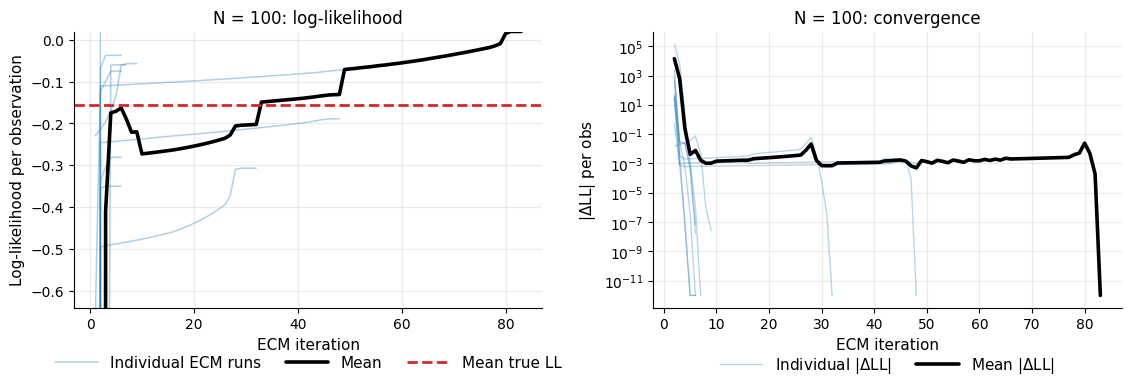

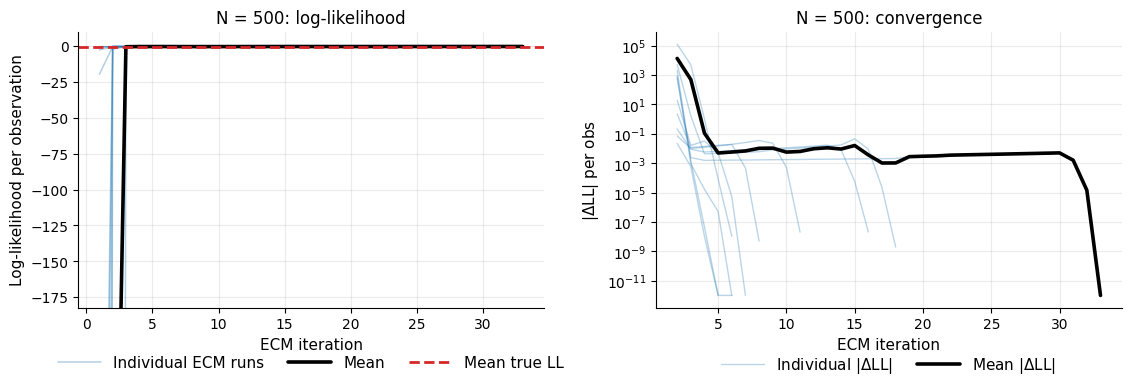

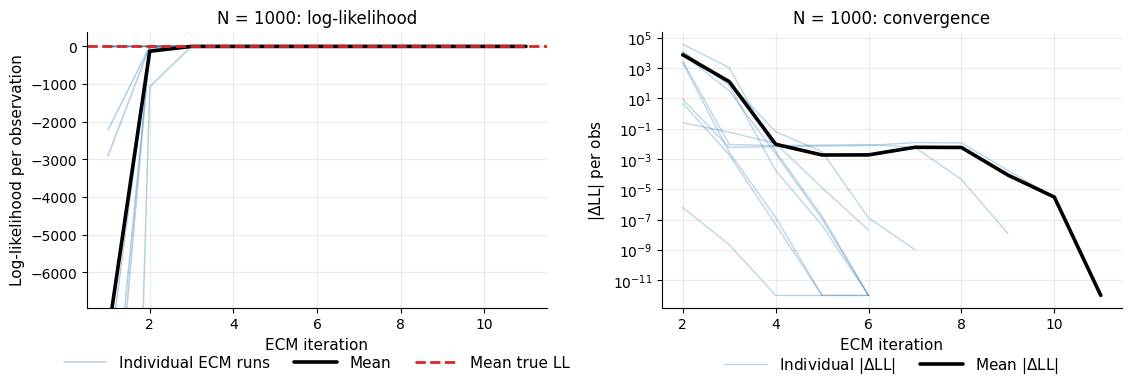

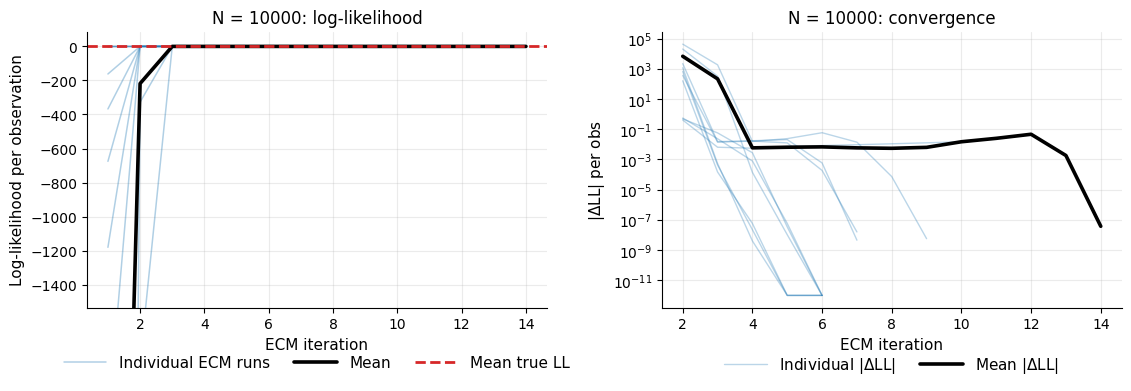

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl


def pad_runs_to_matrix(runs):
    if not runs:
        return np.empty((0, 0))
    L = max(len(r) for r in runs)
    M = np.full((len(runs), L), np.nan, dtype=float)
    for i, r in enumerate(runs):
        rr = np.asarray(r, dtype=float)
        rr = rr[np.isfinite(rr)]
        M[i, :len(rr)] = rr
    return M


def plot_two_panel_per_N(
    ll_hists_all,
    Ns,
    df,
    per_obs=True,
    central="mean",
    run_color="tab:blue",
    run_alpha=0.35,
    run_lw=1.1,
    central_color="black",
    central_lw=2.6,
    ref_color="tab:red",
    ref_lw=2.0,
    grid_alpha=0.25,
    clip_ll_y=True,
    yclip=(5, 95),
    eps=1e-12,
    out_dir=r"C:\Users\hhn54\OneDrive\Dokumenter\Speciale\Figurer\Bivariate_KNown_CTMC",
    file_prefix="ECM",
):
    # Ensure output directory exists
    os.makedirs(out_dir, exist_ok=True)

    mpl.rcParams.update({
        "font.size": 11,
        "axes.titlesize": 12,
        "axes.labelsize": 11,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "axes.linewidth": 0.8,
        "lines.solid_capstyle": "round",
        "savefig.dpi": 400,
    })

    Ns_sorted = sorted([N for N in Ns if len(ll_hists_all.get(N, [])) > 0])
    if not Ns_sorted:
        raise RuntimeError("No likelihood histories found in ll_hists_all.")

    for N in Ns_sorted:
        runs = ll_hists_all.get(N, [])
        if not runs:
            continue

        row = df.loc[df["N"] == N]
        if row.empty:
            raise RuntimeError(f"df missing row for N={N}.")
        ref_val = float(row["True_logLik_mean"].values[0])
        if not np.isfinite(ref_val):
            raise RuntimeError(f"Reference df['True_logLik_mean'] not finite for N={N}.")

        scale = (1.0 / N) if per_obs else 1.0
        ref = ref_val * scale

        M_ll = pad_runs_to_matrix(runs) * scale

        if central.lower() == "median":
            center_ll = np.nanmedian(M_ll, axis=0)
            center_label = "Median"
        else:
            center_ll = np.nanmean(M_ll, axis=0)
            center_label = "Mean"

        itc = np.arange(1, len(center_ll) + 1)

        # ---------------- Figure ----------------
        fig, (ax1, ax2) = plt.subplots(
            1, 2, figsize=(11.2, 3.8),
            constrained_layout=True
        )

        # ===== Left: LL trajectories =====
        all_vals = []
        for j, r in enumerate(runs):
            rr = np.asarray(r, float)
            rr = rr[np.isfinite(rr)]
            if rr.size == 0:
                continue
            rr = rr * scale
            it = np.arange(1, rr.size + 1)
            ax1.plot(
                it, rr,
                color=run_color, alpha=run_alpha, linewidth=run_lw,
                label="Individual ECM runs" if j == 0 else None
            )
            all_vals.append(rr)

        ax1.plot(itc, center_ll, color=central_color, linewidth=central_lw, label=center_label)
        ax1.axhline(ref, color=ref_color, linestyle="--", linewidth=ref_lw, label="Mean true LL")

        ax1.set_title(f"N = {N}: log-likelihood")
        ax1.set_xlabel("ECM iteration")
        ax1.set_ylabel("Log-likelihood per observation" if per_obs else "Log-likelihood")
        ax1.grid(True, alpha=grid_alpha)
        ax1.spines["top"].set_visible(False)
        ax1.spines["right"].set_visible(False)

        # Legend below plot (between axes and x-label)
        ax1.legend(
            frameon=False,
            loc="upper center",
            bbox_to_anchor=(0.5, -0.12),
            ncol=3,
            handlelength=2.8,
            columnspacing=1.6
        )

        if clip_ll_y and all_vals:
            vv = np.concatenate(all_vals)
            vv = vv[np.isfinite(vv)]
            if vv.size:
                lo, hi = np.percentile(vv, yclip)
                lo = min(lo, ref)
                hi = max(hi, ref)
                pad = 0.06 * (hi - lo) if hi > lo else 1.0
                ax1.set_ylim(lo - pad, hi + pad)

        # ===== Right: convergence diagnostic that SHOULD go to 0 =====
        # Plot |ΔLL_k| = |LL_k - LL_{k-1}| (per observation if per_obs=True).
        for j, r in enumerate(runs):
            rr = np.asarray(r, float)
            rr = rr[np.isfinite(rr)]
            if rr.size < 2:
                continue
            rr = rr * scale
            d = np.abs(np.diff(rr))
            it = np.arange(2, rr.size + 1)
            ax2.semilogy(
                it, np.maximum(d, eps),
                color=run_color, alpha=0.30, linewidth=1.0,
                label=r"Individual $|\Delta \mathrm{LL}|$" if j == 0 else None
            )

        # Central curve for |ΔLL|
        if M_ll.shape[1] >= 2:
            dM = np.abs(np.diff(M_ll, axis=1))
            if central.lower() == "median":
                center_d = np.nanmedian(dM, axis=0)
                d_label = r"Median $|\Delta \mathrm{LL}|$"
            else:
                center_d = np.nanmean(dM, axis=0)
                d_label = r"Mean $|\Delta \mathrm{LL}|$"

            itc_d = np.arange(2, len(center_d) + 2)
            ax2.semilogy(
                itc_d, np.maximum(center_d, eps),
                color=central_color, linewidth=central_lw, label=d_label
            )

        ax2.set_title(f"N = {N}: convergence")
        ax2.set_xlabel("ECM iteration")
        ax2.set_ylabel(r"$|\Delta \mathrm{LL}|$ per obs" if per_obs else r"$|\Delta \mathrm{LL}|$")
        ax2.grid(True, which="both", alpha=grid_alpha)
        ax2.spines["top"].set_visible(False)
        ax2.spines["right"].set_visible(False)

        # Legend below plot (between axes and x-label)
        ax2.legend(
            frameon=False,
            loc="upper center",
            bbox_to_anchor=(0.5, -0.12),
            ncol=2,
            handlelength=2.8,
            columnspacing=1.6
        )

        # -------- Save --------
        pdf_path = os.path.join(out_dir, f"{file_prefix}_N{N}_two_panel.pdf")
        png_path = os.path.join(out_dir, f"{file_prefix}_N{N}_two_panel.png")

        fig.savefig(pdf_path, bbox_inches="tight")
        fig.savefig(png_path, bbox_inches="tight", dpi=400)

        plt.show()


# -------- RUN IT --------
plot_two_panel_per_N(
    ll_hists_all=ll_hists_all,
    Ns=Ns,
    df=df,
    per_obs=True,
    central="mean",
    out_dir=r"C:\Users\hhn54\OneDrive\Dokumenter\Speciale\Figurer\Bivariate_KNown_CTMC",
    file_prefix="ECM",
)
